# Swerve Drive

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from celluloid import Camera # For animations
from IPython.display import HTML # For displaying animations

In [2]:
# Helper functions

def vec(x, y):
    return np.array([float(x), float(y)])

def polygon(n, radius, rotate=0):
    points = []
    angle_size = 2 * math.pi / n
    for i in range(n):
        angle = angle_size * i + math.radians(rotate)
        points.append(vec(radius * math.cos(angle), radius * math.sin(angle)))
    return np.array(points)

def draw_vector(start, end, c):
    plt.arrow(start[0], start[1], (end[0]-start[0]), (end[1]-start[1]), fc=c, ec=c,
        head_width=0.2, head_length=0.2,length_includes_head=True)

def draw_line(p1, p2, c):
    plt.plot([p1[0],p2[0]],[p1[1],p2[1]],c+'o-')

def draw_point(loc, c):
    plt.plot(loc[0], loc[1], c + '.')

def draw_polygon(points, c, lines=True):
    if lines:
        for i in range(len(points)-1):
            draw_line(points[i], points[i+1], c)
        draw_line(points[0], points[-1], c)
    else:
        for point in points:
            draw_point(point, c)

class Plot:
    def __init__(self, name=None):
        if name:
            self.fname = name + '.svg'
        else:
            self.fname = None

    def __enter__(self):
        plt.figure(figsize=(8,8))
    def __exit__(self, type, value, traceback):
        plt.axis((-5,5,-5,5))
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axis('off')
        plt.gca().set_aspect('equal', adjustable='box')
        if self.fname:
            plt.savefig(self.fname)
        plt.show()

# plt.xkcd()

ORIGIN = vec(0, 0)

## Frame Definition

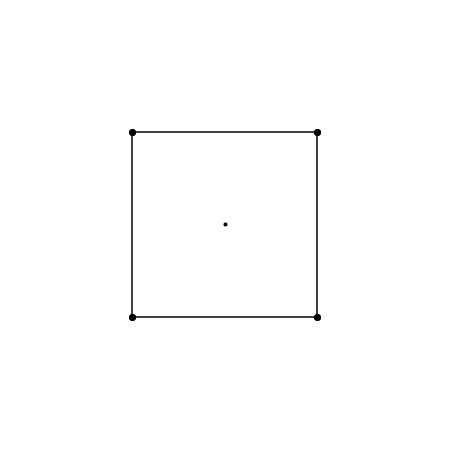

In [3]:
modules = polygon(4, 3, rotate=45)

with Plot('square_frame'):
    draw_point(vec(0,0),'k')
    draw_polygon(modules, 'k', lines=True)

In [4]:
# Input
robot_v = vec(-1,1)
robot_omega = .3

## Translation

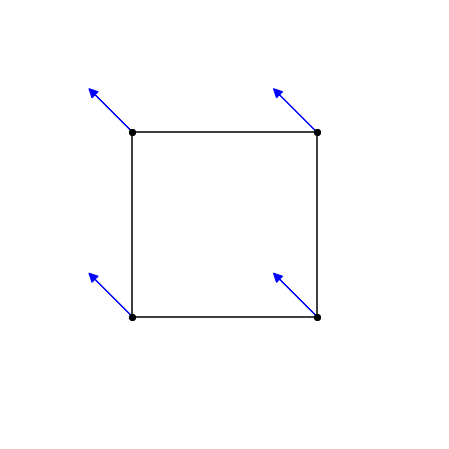

In [5]:
def swerve_translate_only(module, v, draw=False):
    translation_component = v
    output = translation_component
    draw_vector(module, module+translation_component, 'b')
    return output

with Plot('translate_only'):
    draw_polygon(modules, 'k')
    for m in modules:
        swerve_translate_only(m, robot_v, draw='o')

## Rotation

In [6]:
def perpendicularCCW(vector):
    return vec(-vector[1], vector[0])

def swerve(module, v, omega, draw=None):
    translation_component = v
    rotation_component = omega * perpendicularCCW(module)
    output = translation_component + rotation_component
    if draw:
        if 'all' == draw or 't' in draw:
            draw_vector(module, module+translation_component, 'b')
        if 'all' == draw or 'r' in draw:
            draw_vector(module, module+rotation_component, 'r')
        if 'all' == draw or 'o' in draw:
            draw_vector(module, module+output, 'g')
    return output

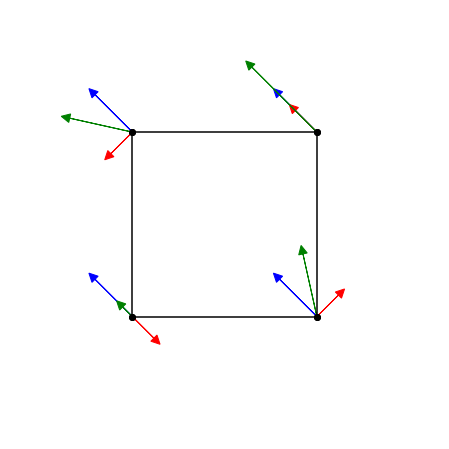

In [7]:
with Plot('square'):
    draw_polygon(modules, 'k')
    for m in modules:
        swerve(m, robot_v, robot_omega, draw='all')

## More Complex Frames

In [8]:
modules = polygon(6, 3)

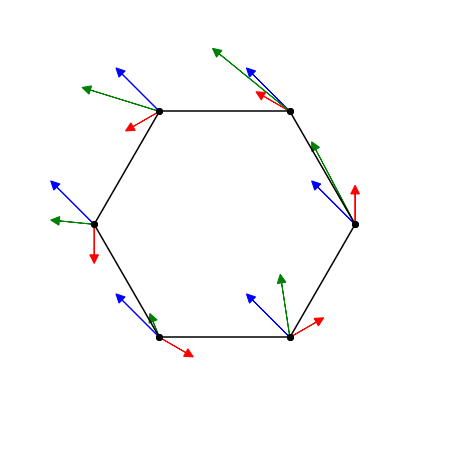

In [9]:
with Plot('hex'):
    draw_polygon(modules, 'k')
    for m in modules:
        swerve(m, robot_v, robot_omega, draw='all')

In [10]:
modules = np.concatenate([polygon(4, 1, rotate=45), polygon(6, 2, rotate=0), polygon(8, 3, rotate=45/2)])

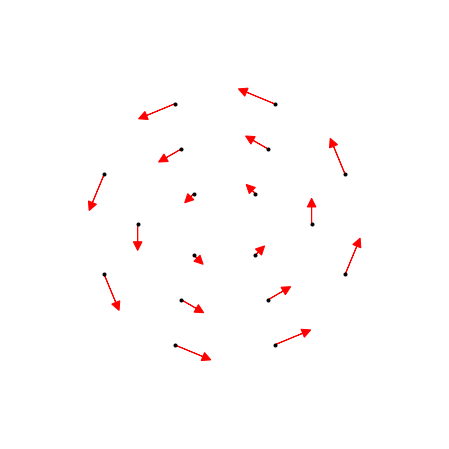

In [11]:
with Plot('fanout'):
    draw_polygon(modules, 'k', lines=False)
    for m in modules:
        swerve(m, robot_v, robot_omega, draw='r')

# Implementation Considerations

In [12]:
# If this is rotated by 45, as in the first example, then by chance pre and post are both ideal.
# Since this never really happens 35 is used

modules = polygon(4, 3, rotate=35)

## Normalization Methods

Better than clamping

In [13]:
outputs = np.array([swerve(m, robot_v, robot_omega) for m in modules])

print('Distances: ', np.linalg.norm(outputs,axis=1))

Distances:  [2.30584285 1.80334026 0.55053495 1.538819  ]


### Pre-normalize

In [14]:
%%latex

$$\frac{1}{\left|\vec{r}\right| + \left|\vec{v}\right|}$$

<IPython.core.display.Latex object>

In [15]:
furthest_module_dist = max([np.linalg.norm(m) for m in modules])

highest_possible_magnitude = (np.linalg.norm(robot_v) + robot_omega * furthest_module_dist)
scale = 1/highest_possible_magnitude

print('Distances: ', np.linalg.norm(scale * outputs,axis=1))

Distances:  [0.99638291 0.77924539 0.23789289 0.66494252]


### Post-normalize

In [16]:
highest_magnitude = np.max(np.linalg.norm(outputs, axis=1))

scale = 1

if highest_magnitude > 1:
    scale = 1/highest_magnitude

print('Distances: ', np.linalg.norm(scale * outputs,axis=1))

Distances:  [1.         0.78207422 0.23875649 0.6673564 ]


## Module to Vector Implementation

Simple polar coordinate transpose

In [17]:
this_module = modules[0]

print('This module: ' + str(this_module))

dist = np.dot(this_module, this_module)

print('Dist: ' + str(dist))

angle = math.degrees(math.atan2(this_module[1], this_module[0]))

print('Angle: ' + str(angle))

This module: [2.45745613 1.72072931]
Dist: 9.0
Angle: 35.0


### Reverse Direction Optimization

Limit maximum travel distance to 90 degrees.

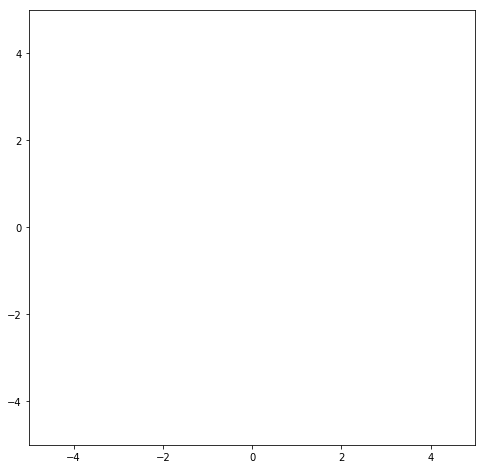

In [18]:
fig = plt.figure()
fig.set_size_inches(8, 8, True)
plt.axis((-5,5,-5,5))
# plt.gca().axis('off')
camera = Camera(fig)
for i in np.arange(0, 90, .5):
    draw_vector(vec(2,2),vec(2+2*math.cos(math.radians(i)), 2+2*math.sin(math.radians(i))), 'b')
    draw_vector(vec(-2,2),vec(-2+2*math.cos(math.radians(i)), 2+2*math.sin(math.radians(i))), 'b')
    draw_vector(vec(2,-2),vec(2+2*math.cos(math.radians(i)), -2+2*math.sin(math.radians(i))), 'b')
    draw_vector(vec(-2,-2),vec(-2-2*math.cos(math.radians(-i)), -2-2*math.sin(math.radians(-i))), 'b')
    
    draw_vector(vec(2,2),vec(2+1*math.cos(math.radians(i)), 2+1*math.sin(math.radians(i))), 'k')
    draw_vector(vec(-2,2),vec(-2+1*math.cos(math.radians(i)), 2+1*math.sin(math.radians(i))), 'k')
    draw_vector(vec(2,-2),vec(2+1*math.cos(math.radians(i)), -2+1*math.sin(math.radians(i))), 'k')
    draw_vector(vec(-2,-2),vec(-2+1*math.cos(math.radians(-i)), -2+1*math.sin(math.radians(-i))), 'k')
    
    draw_point(vec(2,2), 'k')
    draw_point(vec(-2,2), 'k')
    draw_point(vec(2,-2), 'k')
    draw_point(vec(-2,-2), 'k')
    camera.snap()
animation = camera.animate()

animation.save('three_of_four.mp4', fps=60, bitrate=3200, dpi=100)

HTML(animation.to_html5_video())

### Cosine Error Scaling

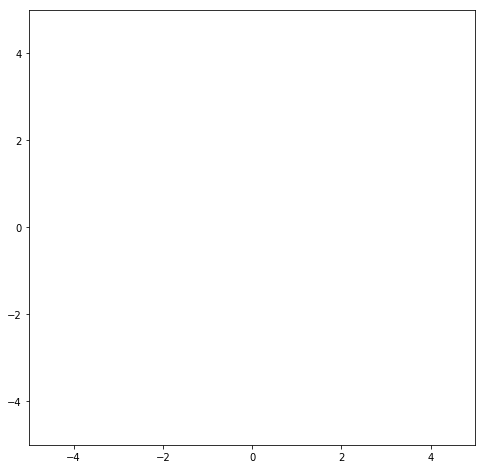

In [19]:
fig = plt.figure()
fig.set_size_inches(8, 8, True)
plt.axis((-5,5,-5,5))
# plt.gca().axis('off')
camera = Camera(fig)
for i in np.arange(.01, 90, .5):
    mult = math.cos(math.radians(90-i))
    draw_vector(vec(2,2),vec(2+mult*2*math.cos(math.radians(i)), 2+mult*2*math.sin(math.radians(i))), 'b')
    draw_vector(vec(-2,2),vec(-2+mult*2*math.cos(math.radians(i)), 2+mult*2*math.sin(math.radians(i))), 'b')
    draw_vector(vec(2,-2),vec(2+mult*2*math.cos(math.radians(i)), -2+mult*2*math.sin(math.radians(i))), 'b')
    draw_vector(vec(-2,-2),vec(-2-mult*2*math.cos(math.radians(-i)), -2-mult*2*math.sin(math.radians(-i))), 'b')
    
    draw_vector(vec(2,2),vec(2+1*math.cos(math.radians(i)), 2+1*math.sin(math.radians(i))), 'k')
    draw_vector(vec(-2,2),vec(-2+1*math.cos(math.radians(i)), 2+1*math.sin(math.radians(i))), 'k')
    draw_vector(vec(2,-2),vec(2+1*math.cos(math.radians(i)), -2+1*math.sin(math.radians(i))), 'k')
    draw_vector(vec(-2,-2),vec(-2+1*math.cos(math.radians(-i)), -2+1*math.sin(math.radians(-i))), 'k')
    
    draw_point(vec(2,2), 'k')
    draw_point(vec(-2,2), 'k')
    draw_point(vec(2,-2), 'k')
    draw_point(vec(-2,-2), 'k')
    camera.snap()
animation = camera.animate()

animation.save('three_of_four_cos.mp4', fps=60, bitrate=3200, dpi=100)

HTML(animation.to_html5_video())

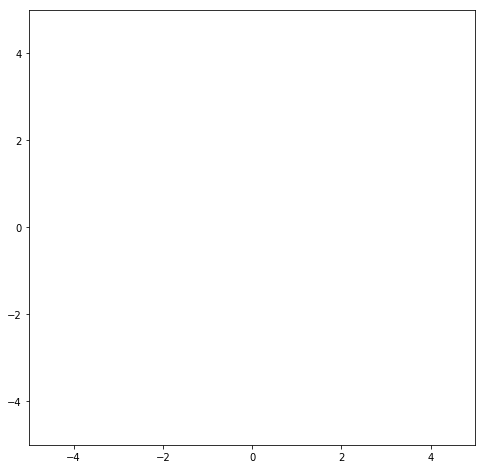

In [20]:
fig = plt.figure()
fig.set_size_inches(8, 8, True)
plt.axis((-5,5,-5,5))
# plt.gca().axis('off')
camera = Camera(fig)
for i in np.arange(.01, 90, .5):
    mult = math.cos(math.radians(90-i))
    draw_vector(vec(2,2),vec(2+mult*2*math.cos(math.radians(i)), 2+mult*2*math.sin(math.radians(i))), 'b')
    draw_vector(vec(-2,2),vec(-2+mult*2*math.cos(math.radians(i)), 2+mult*2*math.sin(math.radians(i))), 'b')
    draw_vector(vec(2,-2),vec(2+mult*2*math.cos(math.radians(i)), -2+mult*2*math.sin(math.radians(i))), 'b')
    draw_vector(vec(-2,-2),vec(-2-mult*2*math.cos(math.radians(-i)), -2-mult*2*math.sin(math.radians(-i))), 'b')
    
    mult = mult**3
    draw_vector(vec(2,2),vec(2+mult*2*math.cos(math.radians(i)), 2+mult*2*math.sin(math.radians(i))), 'g')
    draw_vector(vec(-2,2),vec(-2+mult*2*math.cos(math.radians(i)), 2+mult*2*math.sin(math.radians(i))), 'g')
    draw_vector(vec(2,-2),vec(2+mult*2*math.cos(math.radians(i)), -2+mult*2*math.sin(math.radians(i))), 'g')
    draw_vector(vec(-2,-2),vec(-2-mult*2*math.cos(math.radians(-i)), -2-mult*2*math.sin(math.radians(-i))), 'g')
    
    draw_vector(vec(2,2),vec(2+1*math.cos(math.radians(i)), 2+1*math.sin(math.radians(i))), 'k')
    draw_vector(vec(-2,2),vec(-2+1*math.cos(math.radians(i)), 2+1*math.sin(math.radians(i))), 'k')
    draw_vector(vec(2,-2),vec(2+1*math.cos(math.radians(i)), -2+1*math.sin(math.radians(i))), 'k')
    draw_vector(vec(-2,-2),vec(-2+1*math.cos(math.radians(-i)), -2+1*math.sin(math.radians(-i))), 'k')
    
    draw_point(vec(2,2), 'k')
    draw_point(vec(-2,2), 'k')
    draw_point(vec(2,-2), 'k')
    draw_point(vec(-2,-2), 'k')
    camera.snap()
animation = camera.animate()

animation.save('three_of_four_cos.mp4', fps=60, bitrate=3200, dpi=100)

HTML(animation.to_html5_video())